# 以相似度为训练目标

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 训练数据生成器

In [5]:
!git clone https://github.com/daibiaoxuwu/3182
!git clone https://github.com/daibiaoxuwu/3182b


Cloning into '3182'...
remote: Enumerating objects: 58593, done.
remote: Counting objects: 100% (58593/58593), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 58593 (delta 58585), reused 58593 (delta 58585), pack-reused 0
Receiving objects: 100% (58593/58593), 24.11 MiB | 7.50 MiB/s, done.
Resolving deltas: 100% (58585/58585), done.
Checking out files: 100% (58591/58591), done.
Cloning into '3182b'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 160 (delta 0), reused 160 (delta 0), pack-reused 0
Receiving objects: 100% (160/160), 862.78 KiB | 724.00 KiB/s, done.


In [0]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt

datasizex = 7
datasizey = 7
picsizex = 10
picsizey = 47
picnum = 30
lowpercent = 125.0
highpercent = 233.0
enhance = 4
def read_data(path1,path2):

  x_train0 = []
  y_train0 = dict()
  idxes = dict()

  #read clock
  #read and /255
  for filename in os.listdir(path2):
      if 'git' in filename: continue
      ans = cv2.imread(os.path.join(path2,filename),cv2.IMREAD_GRAYSCALE).astype('float32')     
      ans = np.clip((ans-lowpercent)/(highpercent - lowpercent),0,1)
      y_train0[int(filename[:-4])]=ans

  keys = list(y_train0.keys())
  
  #read data
  #add an axis and /255
  
  filelist = os.listdir(path1)
  random.shuffle(filelist)
  index = 0
  for filename in filelist:
      if 'git' in filename or 'c.jpg' in filename: continue
      ##################################
      ##################################
      ##################################
      ##################################
      ##################################
      ftime = int(filename.split('_')[0])
      ##################################
      ##################################
      ##################################
      ##################################
      ##################################
      value = max(filter(lambda t:t<ftime,keys))
      if(abs(ftime-value)<3000):continue

      x_train0.append(cv2.imread(os.path.join(path1,filename)).astype('float32')/255.0)
      if value not in idxes:idxes[value]=[index]
      else: idxes[value].append(index)
      index += 1

  #index data
  print(len(x_train0),index,len(y_train0),len(idxes.keys()))
  lens = [len(i) for i in idxes.values()]
  print(min(lens),max(lens),np.average(lens))
  for key,val in list(idxes.items()):
    if len(val)<picnum:
      idxes.pop(key)
  

  #generator
  def data_generator(ikeys_t):
    while True:
      dataout = []
      for i in range(picnum):dataout.append([])
      ansout = []
      for train2 in range(32):
        '''
        while True:
          key = random.choice(ikeys_t)
          idx2 = random.sample(idxes[key],picnum)
          posx = random.randint(0,picsizex-datasizex)
          posy = random.randint(0,picsizey-datasizey)
          pic = x_train0[idx2[i]][posx:posx+datasizex,posy:posy+datasizey,:]
          if(np.sum(pic) < 175):
            for i in range(picnum):
              dataout[i].append(x_train0[idx2[i]][posx:posx+datasizex,posy:posy+datasizey,:])
            ansout.append(y_train0[key][posx:posx+datasizex,posy:posy+datasizey])
            break
        '''
        key = random.choice(ikeys_t)
        idx2 = random.sample(idxes[key],picnum)
        posx = random.randint(0,picsizex-datasizex)
        posy = random.randint(0,picsizey-datasizey)
        pic = x_train0[idx2[i]][posx:posx+datasizex,posy:posy+datasizey,:]
        for i in range(picnum):
          dataout[i].append(x_train0[idx2[i]][posx:posx+datasizex,posy:posy+datasizey,:])
        ansout.append(y_train0[key][posx*enhance:(posx+datasizex)*enhance,posy*enhance:(posy+datasizey)*enhance])
      yield [np.stack(data2) for data2 in dataout],np.stack(ansout)
  def pic_generator(ikeys_t):
    while True:
      key = random.choice(ikeys_t)
      idx2 = random.sample(idxes[key],picnum)
      data=[x_train0[i] for i in idx2]
      ans=y_train0[key]
      yield data,ans

  #split
  ikeys = list(idxes.keys())
  random.shuffle(ikeys)
  ltrain = int(len(ikeys)*0.8)  
  train_generator = data_generator(ikeys[:ltrain])
  test_generator = data_generator(ikeys[ltrain:])
  train_pic_generator = pic_generator(ikeys[:ltrain])
  test_pic_generator = pic_generator(ikeys[ltrain:])

  return train_generator,test_generator,train_pic_generator,test_pic_generator



In [6]:

from matplotlib import pyplot as plt
train_generator,test_generator,train_pic_generator,test_pic_generator = read_data('3182','3182b')


55630 55630 344 305
117 211 182.39344262295083


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


614.6482
0.0 1.0


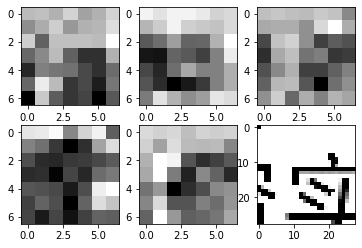

In [7]:
data,ans = next(train_generator)
for pics in data:
  for i in range(6):
    plt.subplot(231+i)
    plt.imshow(pics[i,:,:,0],cmap='gray')
ans[0,0,0]=0
ans[0,1,0]=1
plt.imshow(ans[0],cmap='gray')
print(np.sum(ans[0]))
print(np.min(ans[0]),np.max(ans[0]))

# 数据初始化完成。


# 装载Tensorflow

In [8]:

from __future__ import absolute_import, division, print_function, unicode_literals

# 安装 TensorFlow
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

TensorFlow 2.x selected.



# 搭建模型和训练
现在的网络去掉dropout则可以拟合10张图片，
但是加上dropout就拟合不了。
从7张拟合5张的，则可以在两个epoch（每个epoch抽取60000次）内到80%。

继续训练20张，一个epoch就到60%。

In [0]:
inputs = [tf.keras.layers.Input(shape=(datasizex,datasizey,3))  for i in range(picnum)]
#inputs = tf.keras.layers.Input(shape=(5,12,12,1))
convg1 = 0
convd1 = 0
convh1 = inputs
inputs_big = inputs
for layernum in range(8):
  conv_a1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
  conva1 = [conv_a1(convh1[i]) for i in range(picnum)]
  #drop_a1 = tf.keras.layers.Dropout(0.2)
  #conva1 = drop_a1(conva1)
  conv_b1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
  convb1 = [conv_b1(conva1[i]) for i in range(picnum)]
  

  conv_c1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
  convc1 = [conv_c1(inputs_big[i]) for i in range(picnum)]
  #drop_b1 = tf.keras.layers.Dropout(0.2)
  #convc1 = drop_a1(convc1)
  conv_d1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
  convd1 = [conv_d1(convc1[i]) for i in range(picnum)]
  

  convs1 = tf.stack(convb1)
  convf1 = [
      tf.math.reduce_max(convs1, axis=[0]),
      tf.math.reduce_mean(convs1, axis=[0]),
      tf.math.reduce_min(convs1, axis=[0]),
  ]

  conv_g1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
  convg1 = [conv_g1(convf1[i]) for i in range(3)]

  drop_c1 = tf.keras.layers.Dropout(0.2)
  convh1 = [drop_c1(tf.concat(convg1+[convd1[i]],axis=3)) for i in range(picnum)]
  if(layernum % 3 == 1):
    convex1 = tf.keras.layers.Conv2D(32, (1, 1), padding = 'Same',  activation='relu')
    convh1 = [tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None)(i) for i in convh1]
    convh1 = [convex1(convh1[i]) for i in range(picnum)]
    inputs_big = [tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None)(i) for i in inputs_big]
convh3 = tf.concat(convg1+convd1,axis=3)

convx1 = tf.keras.layers.Conv2D(64, (3, 3), padding = 'Same',  activation='relu')(convh3)
convx2 = tf.keras.layers.Dropout(0.2)(convx1)
convx3 = tf.keras.layers.Conv2D(64, (3, 3), padding = 'Same', activation='relu')(convx2)
'''
convx3 = tf.keras.layers.Flatten()(convx2)

#keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)
convx4 = tf.keras.layers.Dropout(0.2)(convx3)

convy1 = tf.keras.layers.Dense(21*45)(convx4)
#convy3 = tf.keras.layers.Dense(10,activation='softmax')(convy1)
convy4 = tf.keras.layers.Reshape([21,45])(convy1)
'''

convx4 = tf.keras.layers.Conv2D(1, (3, 3), padding = 'Same')(convx3)

model = tf.keras.Model(inputs=inputs, outputs=convx4)


In [24]:
#tf.reduce_mean(tf.image.ssim(reconstructed, truth, 1.0))
model.compile(optimizer='adam',#tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                #loss=lambda y_pred,y_true:1-tf.reduce_mean(tf.image.ssim_multiscale(tf.clip_by_value(y_pred,0,1), y_true, 255))#-tf.reduce_mean(tf.image.psnr(tf.clip_by_value(y_pred,0,1), y_true, 1.0))
              loss='mse',
              metrics=['mse']
              )
            
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 7, 7, 3)]    0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 7, 7, 3)]    0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 7, 7, 3)]    0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 7, 7, 3)]    0                                            
____________________________________________________________________________________________

# 测试正确率：

In [0]:
from skimage.metrics import peak_signal_noise_ratio,structural_similarity, mean_squared_error
class show_accuracy(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if epoch % 5 == 1:
      data,ans = next(test_generator)
      data = [data[x][5][np.newaxis,:,:,:] for x in range(picnum)]
      ans = ans[5]
      import matplotlib
      cmap = matplotlib.cm.gray 
      cmap.set_bad(color='black')

      pred = model.predict(data) #shape:(1,11,11,1) because last layer is conv not dense
      #pred = np.clip(pred,0,1)
      #pred = (pred-np.min(pred))/(np.max(pred)-np.min(pred))
      #pred = softmax(pred)
      pred[0,0,0,0]=0
      pred[0,-1,-1,0]=1
      ans[0,0]=0
      ans[-1,-1]=1
      for i in range(6):
        plt.subplot(231+i)
        plt.imshow(data[i][0,:,:,0],cmap=cmap)
      plt.show()
      plt.subplot(121)
      plt.imshow(pred[0,:,:,0],cmap=cmap)
      plt.colorbar()
      #ans = np.clip((ans-np.percentile(ans,10))/(np.percentile(ans,90)-np.percentile(ans,10)),0,1)
      plt.subplot(122)
      plt.imshow(ans,cmap=cmap)
      plt.colorbar()
      plt.show()
#      print('psnr',peak_signal_noise_ratio(np.clip(pred[0,:,:,0],0,1),ans))
#      print('ssim',structural_similarity(np.clip(pred[0,:,:,0],0,1),ans))
      print('mse',mean_squared_error(np.clip(pred[0,:,:,0],0,1),ans))



# 开始训练

In [0]:
# Suppress some level of logs
import logging
logging.getLogger("tensorflow").setLevel(logging.WARN)

In [0]:
ckpt_filename = tf.train.latest_checkpoint("/content/drive/My Drive/checkpoints/training_15_archive")
print(ckpt_filename)
model.load_weights(ckpt_filename)#,by_name=True)

In [0]:
checkpoint_path = "/content/drive/My Drive/checkpoints/training_21/cp-{epoch:02d}-{val_loss:.4f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,monitor='val_loss')#,save_best_only=True,mode='min')
show_accuracy_callback = show_accuracy()

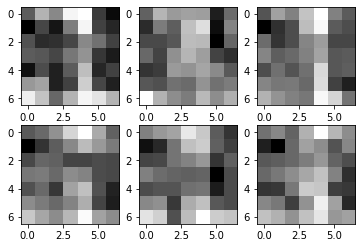

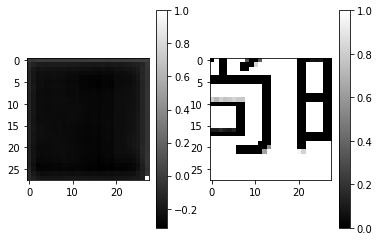

mse 0.7095870938537143


In [26]:
show_accuracy_callback.on_epoch_end(epoch=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 50 steps
Epoch 1/200
500/500 - 466s - loss: 0.1496 - mse: 0.1496 - val_loss: 0.1408 - val_mse: 0.1408
Epoch 2/200


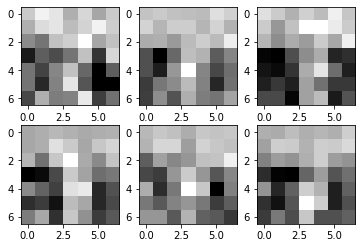

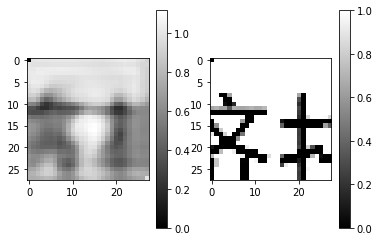

mse 0.11126304063950554
500/500 - 420s - loss: 0.1381 - mse: 0.1381 - val_loss: 0.1373 - val_mse: 0.1373
Epoch 3/200
500/500 - 419s - loss: 0.1341 - mse: 0.1341 - val_loss: 0.1336 - val_mse: 0.1336
Epoch 4/200
500/500 - 419s - loss: 0.1308 - mse: 0.1308 - val_loss: 0.1310 - val_mse: 0.1310
Epoch 5/200
500/500 - 418s - loss: 0.1289 - mse: 0.1289 - val_loss: 0.1297 - val_mse: 0.1297
Epoch 6/200
500/500 - 419s - loss: 0.1272 - mse: 0.1272 - val_loss: 0.1299 - val_mse: 0.1299
Epoch 7/200


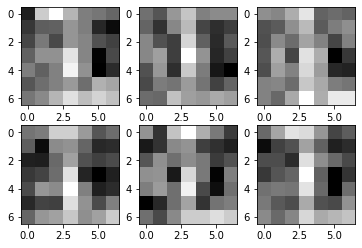

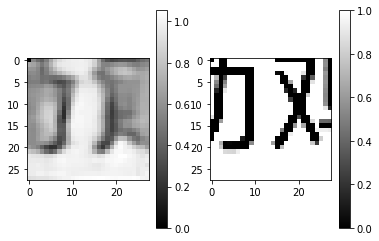

mse 0.1286836246007768
500/500 - 419s - loss: 0.1261 - mse: 0.1261 - val_loss: 0.1292 - val_mse: 0.1292
Epoch 8/200
500/500 - 419s - loss: 0.1250 - mse: 0.1250 - val_loss: 0.1280 - val_mse: 0.1280
Epoch 9/200
500/500 - 419s - loss: 0.1239 - mse: 0.1239 - val_loss: 0.1286 - val_mse: 0.1286
Epoch 10/200
500/500 - 419s - loss: 0.1226 - mse: 0.1226 - val_loss: 0.1286 - val_mse: 0.1286
Epoch 11/200
500/500 - 418s - loss: 0.1217 - mse: 0.1217 - val_loss: 0.1285 - val_mse: 0.1285
Epoch 12/200


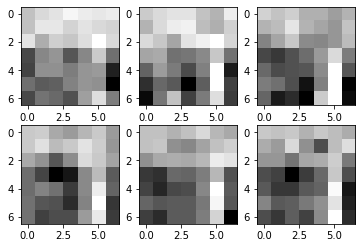

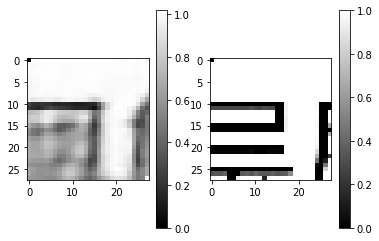

mse 0.09495446323854922
500/500 - 419s - loss: 0.1210 - mse: 0.1210 - val_loss: 0.1280 - val_mse: 0.1280
Epoch 13/200
500/500 - 418s - loss: 0.1202 - mse: 0.1202 - val_loss: 0.1281 - val_mse: 0.1281
Epoch 14/200
500/500 - 418s - loss: 0.1193 - mse: 0.1193 - val_loss: 0.1269 - val_mse: 0.1269
Epoch 15/200
500/500 - 418s - loss: 0.1183 - mse: 0.1183 - val_loss: 0.1271 - val_mse: 0.1271
Epoch 16/200
500/500 - 418s - loss: 0.1178 - mse: 0.1178 - val_loss: 0.1272 - val_mse: 0.1272
Epoch 17/200


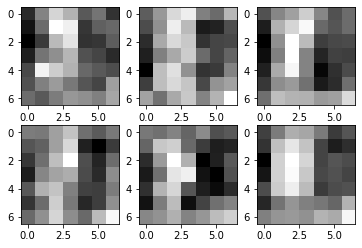

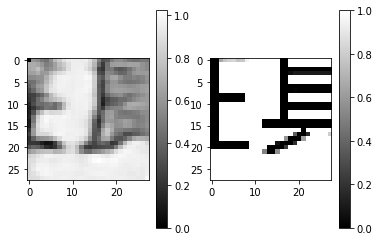

mse 0.11890872628737097
500/500 - 419s - loss: 0.1172 - mse: 0.1172 - val_loss: 0.1283 - val_mse: 0.1283
Epoch 18/200
500/500 - 419s - loss: 0.1163 - mse: 0.1163 - val_loss: 0.1274 - val_mse: 0.1274
Epoch 19/200
500/500 - 419s - loss: 0.1158 - mse: 0.1158 - val_loss: 0.1260 - val_mse: 0.1260
Epoch 20/200
500/500 - 418s - loss: 0.1152 - mse: 0.1152 - val_loss: 0.1264 - val_mse: 0.1264
Epoch 21/200
500/500 - 418s - loss: 0.1142 - mse: 0.1142 - val_loss: 0.1278 - val_mse: 0.1278
Epoch 22/200


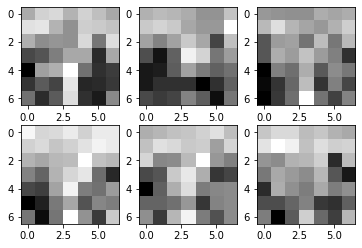

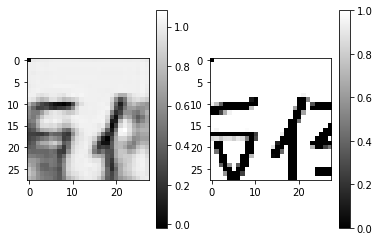

mse 0.0844931754600832
500/500 - 419s - loss: 0.1135 - mse: 0.1135 - val_loss: 0.1282 - val_mse: 0.1282
Epoch 23/200
500/500 - 419s - loss: 0.1133 - mse: 0.1133 - val_loss: 0.1276 - val_mse: 0.1276
Epoch 24/200
500/500 - 419s - loss: 0.1127 - mse: 0.1127 - val_loss: 0.1273 - val_mse: 0.1273
Epoch 25/200
500/500 - 418s - loss: 0.1117 - mse: 0.1117 - val_loss: 0.1275 - val_mse: 0.1275
Epoch 26/200
500/500 - 418s - loss: 0.1116 - mse: 0.1116 - val_loss: 0.1274 - val_mse: 0.1274
Epoch 27/200


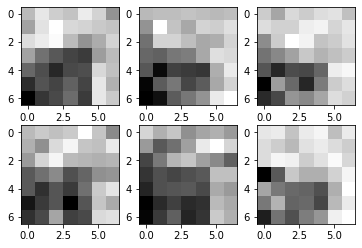

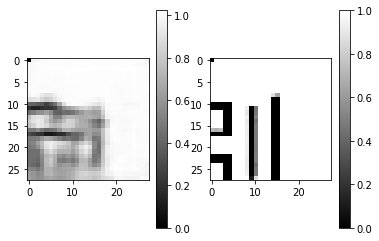

mse 0.08750456350199921
500/500 - 419s - loss: 0.1109 - mse: 0.1109 - val_loss: 0.1263 - val_mse: 0.1263
Epoch 28/200
500/500 - 418s - loss: 0.1108 - mse: 0.1108 - val_loss: 0.1251 - val_mse: 0.1251
Epoch 29/200
500/500 - 418s - loss: 0.1103 - mse: 0.1103 - val_loss: 0.1258 - val_mse: 0.1258
Epoch 30/200
500/500 - 418s - loss: 0.1098 - mse: 0.1098 - val_loss: 0.1263 - val_mse: 0.1263
Epoch 31/200
500/500 - 419s - loss: 0.1092 - mse: 0.1092 - val_loss: 0.1258 - val_mse: 0.1258
Epoch 32/200


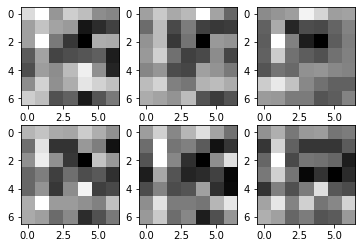

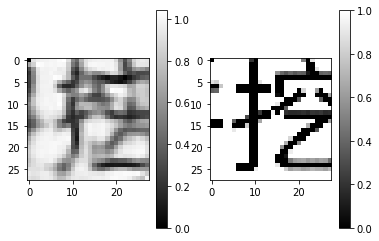

mse 0.12071367846648322
500/500 - 419s - loss: 0.1090 - mse: 0.1090 - val_loss: 0.1271 - val_mse: 0.1271
Epoch 33/200
500/500 - 418s - loss: 0.1084 - mse: 0.1084 - val_loss: 0.1256 - val_mse: 0.1256
Epoch 34/200


In [0]:
if True:
  if not os.path.exists(checkpoint_dir):
    model.fit_generator(train_generator,epochs=200,steps_per_epoch=500,validation_data=test_generator,validation_steps=50,validation_freq=1,verbose=2,callbacks=[cp_callback,show_accuracy_callback])


# 验证模型

In [0]:
def predict_pic(xpics,model):
  # xpic: array of 5 with size(22,52,1)
  picout = np.zeros((picsizex*enhance,picsizey*enhance),dtype=np.float32)
  piclayer = np.zeros((picsizex*enhance,picsizey*enhance),dtype=int)
  for posx in range(0,picsizex+1-datasizex):
    for posy in range(0,picsizey+1-datasizey):
      dataout = [pic[np.newaxis,posx:posx+datasizex,posy:posy+datasizey,:] for pic in xpics]
      pred = model.predict(dataout)
      picout[posx*enhance:(posx+datasizex)*enhance,posy*enhance:(posy+datasizey)*enhance] += pred[0,:,:,0]
      piclayer[posx*enhance:(posx+datasizex)*enhance,posy*enhance:(posy+datasizey)*enhance] += np.ones((datasizex*enhance,datasizey*enhance),dtype=int)
  picout /= piclayer
  return picout


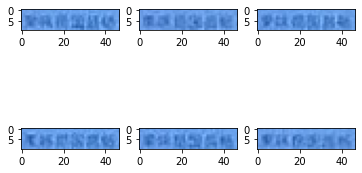

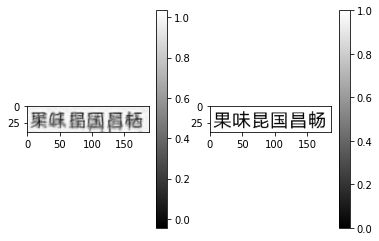

In [22]:
data,ans = next(test_pic_generator)

import matplotlib
cmap = matplotlib.cm.gray 
cmap.set_bad(color='black')

pred = predict_pic(data,model)

for i in range(6):
  plt.subplot(231+i)
  b,g,r = cv2.split(data[i])       # get b,g,r
  rgb_img = cv2.merge([r,g,b])     # switch it to rgb
  plt.imshow(rgb_img)

plt.show()      
pred[0,0]=0
pred[-1,-1]=1
ans[0,0]=0
ans[-1,-1]=1
plt.subplot(121)
plt.imshow(pred,cmap=cmap)
plt.colorbar()
#ans = np.clip((ans-np.percentile(ans,10))/(np.percentile(ans,90)-np.percentile(ans,10)),0,1)
plt.subplot(122)
plt.imshow(ans,cmap=cmap)
plt.colorbar()
plt.show()
#      print('psnr',peak_signal_noise_ratio(np.clip(pred[0,:,:,0],0,1),ans))
#      print('ssim',structural_similarity(np.clip(pred[0,:,:,0],0,1),ans))
#print('mse',mean_squared_error(np.clip(pred,0,1),ans))
